In [1]:
import sys
path_append = "../"
sys.path.append(path_append)  # Go up one directory from where you are.

In [ ]:
import os
import pandas as pd
import torchvision
import torchvision.datasets as dset
import torch
from torchvision import transforms
import albumentations
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Paths
dataroot = path_append +  "../data/"
animal_path = os.path.join(dataroot, "animal/afhq/")
celeba_path = os.path.join(dataroot, "celeba/")

# Constants
image_size = 128

In [3]:
# Constants
image_size = 128

# Load animal dataset from specific categories
def load_animal_dataset_by_class(animal_path, mode):
    categories = ['cat', 'dog']  # Add more categories as needed
    images = []
    classes = []
    for category in categories:
        category_path = os.path.join(animal_path, mode, category)
        category_images = os.listdir(category_path)
        images.extend([os.path.join(category_path, img) for img in category_images])
        classes.extend([category] * len(category_images))
    return pd.DataFrame({'path': images, 'class': classes})

animal_train_df = load_animal_dataset_by_class(animal_path, 'train')
animal_val_df = load_animal_dataset_by_class(animal_path, 'val')

# Encode classes
label_encoder = LabelEncoder()
animal_train_df['class'] = label_encoder.fit_transform(animal_train_df['class'])
animal_val_df['class'] = label_encoder.transform(animal_val_df['class'])

# Get the number of classes
num_classes = max(animal_train_df['class']) + 1
print(f"Number of classes: {num_classes}")


In [5]:
for mode, df in zip(["train", "val"],[animal_train_df, animal_val_df]):
    classes = []
    paths = []
    for image in df['images']:
        class_ = image.split('_')[1]
        classes.append(class_)
        paths.append(animal_path + mode +'/'+class_+'/'+image)
    df['classes'] = classes
    
    df['path'] = paths
animal_train_df = animal_train_df.drop("images",axis=1)
animal_val_df = animal_val_df.drop("images",axis=1)

In [6]:
labelencoder = LabelEncoder()
animal_train_df["classes"] = labelencoder.fit_transform(animal_train_df["classes"].values)+2

In [7]:
animal_train_df

,classes,path
0,2,../data/animal/afhq/train/cat/flickr_cat_00000...
1,2,../data/animal/afhq/train/cat/flickr_cat_00000...
2,2,../data/animal/afhq/train/cat/flickr_cat_00000...
3,2,../data/animal/afhq/train/cat/flickr_cat_00000...
4,2,../data/animal/afhq/train/cat/flickr_cat_00000...
...,...,...
9887,3,../data/animal/afhq/train/dog/pixabay_dog_0040...
9888,3,../data/animal/afhq/train/dog/pixabay_dog_0040...
9889,3,../data/animal/afhq/train/dog/pixabay_dog_0040...
9890,3,../data/animal/afhq/train/dog/pixabay_dog_0040...


In [8]:
# Load CelebA dataset
def get_celeba_dataset(split):
    return dset.CelebA(root=celeba_path, split=split, transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]), download=False)

celeba_trainset = get_celeba_dataset("train")
celeba_testset = get_celeba_dataset("test")


In [9]:
import torch.nn.functional as F

# Custom dataset
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, ukiyoe_df, celeba_dataset, num_classes):
        self.ukiyoe_data = ukiyoe_df
        self.celeba_data = celeba_dataset
        self.num_classes = num_classes
        self.total_len = len(ukiyoe_df)
        self.index_cycle = -1
        self.index_map = [list(range(i, i+self.total_len)) for i in range(0, len(celeba_dataset) - self.total_len + 1, self.total_len)]
        self.albu_transforms = albumentations.Compose([
            albumentations.Resize(image_size, image_size),
            albumentations.CenterCrop(image_size, image_size),
            albumentations.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __getitem__(self, index):
        if index < self.total_len:
            image_path = self.ukiyoe_data.iloc[index]['path']
            image = Image.open(image_path)
            image = self.albu_transforms(image=np.array(image))['image']
            image = torch.FloatTensor(np.transpose(image, (2, 0, 1)))
            label = self.ukiyoe_data.iloc[index]['class']
            y = F.one_hot(torch.tensor(label, dtype=torch.long), num_classes=self.num_classes)
            return image, y
        else:
            image, attributes = self.celeba_data[self.index_map[self.index_cycle][index-self.total_len]]
            y = torch.zeros(self.num_classes, dtype=torch.long)
            y[0] = 1    
            return image, y

    def __len__(self):
        self.index_cycle = (self.index_cycle + 1) % len(self.index_map)
        return self.total_len * 2

In [10]:
# Example animal_train_df
celeba_animal_dataset = CombinedDataset(celeba_trainset, animal_train_df, num_classes)

# Model instantiation

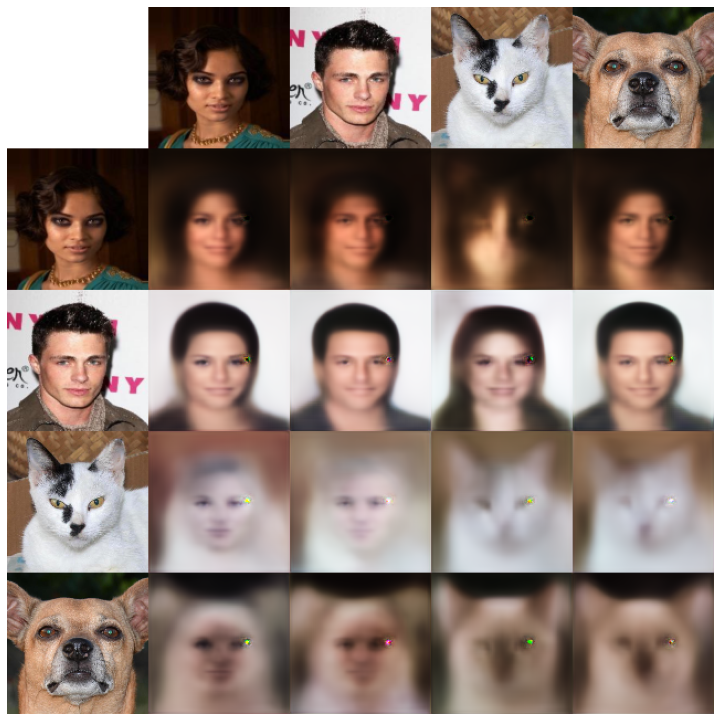

Epoch-11 Opt-Adam lr_ERP: 0.0001806631012097003
[11/4000][150/310][Time 45.14]
E: 0.0595	R: 0.0634	P: 0.3282	Inf: 0.0614	Gen: 0.1938	Rec: 0.1958


KeyboardInterrupt: 

In [14]:
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig

data_config = DataConfig(dataset_name = 'celebA_animal', task_type='multi_class_classification', obs_shape=[3, 128, 128], label_size=num_classes, \
                        show_image_indices=[9005, 6000, 10, 200])

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(core_model = 'stylegan', encoder_model = 'none')

ml_params.model.core_config.d_model = 512
ml_params.model.core_config.num_layers = 5
ml_params.model.core_config.dropout = 0.0
ml_params.optimization.decay_rate_100k = 0.05
ml_params.training.num_epoch = 1000

first_data = celeba_animal_dataset[0]
X, y = first_data

print(f"Input shape: {X.shape}")
print(f"Label shape: {y.shape}")

print(f"Total number of samples in trainset: {len(celeba_animal_dataset)}")